In [1]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        # 只有3个卷积层
        super(SRCNN, self).__init__() 
        # 输入通道数为1，因为只有一个Y通道；输出通道数为64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)  
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):  # 执行流程
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [2]:
import os
from torch.utils.data import Dataset
import torchvision.transforms as transform
import cv2 as cv
from PIL import Image

class dataLoader(Dataset):
    def __init__(self, imagePath, zoomFactor):
        super(dataLoader, self).__init__()
        self.imageList = [os.path.join(imagePath, file) for file in os.listdir(imagePath)]
        self.cropSize = 32
        # 按照论文方法，制作降质图像
        self.downTransform = transform.Compose([transform.CenterCrop(self.cropSize),
                                            transform.Resize(self.cropSize // zoomFactor),
                                            transform.Resize(self.cropSize, interpolation=Image.BICUBIC),
                                            transform.ToTensor()])
        # 制作label
        self.labelTransform = transform.Compose([transform.CenterCrop(self.cropSize),
                                                 transform.ToTensor()])
    def __getitem__(self, index):
        img = Image.open(self.imageList[index]).convert('YCbCr')
        y, _, _ = img.split()
        label = y.copy()
        downImg = self.downTransform(y)
        label = self.labelTransform(label)
        return downImg, label
    def __len__(self):
        return len(self.imageList)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
from skimage.metrics import structural_similarity



device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

torch.manual_seed(0)
zoomFactor = 2
batchSize = 1
epochs = 500


trainset = dataLoader("./set5", zoomFactor = zoomFactor)
testset = dataLoader("./set5", zoomFactor = zoomFactor)

# 加载数据集
trainloader = DataLoader(dataset=trainset, batch_size=batchSize, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=batchSize, shuffle=False)

# 实例化网络模型
model = SRCNN().to(device)
# 采用论文中的均方误差损失函数
criterion = nn.MSELoss()
# 在这里的优化器采用了Adam
# 对每一层的学习率都进行设置
# 其中conv1的学习率将使用外层的0.0001
optimizer = optim.Adam(
    [
        {"params": model.conv1.parameters()},
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.0001,
)

# 训练epochs轮
for epoch in range(epochs):



    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        # 将上一次for循环的梯度清零
        optimizer.zero_grad()
        out = model(input)
        # 计算误差
        loss = criterion(out, target)
        # 反向传播
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")  # 打印每一个epoch和其损失率

    # 经历一个epoch训练以后，在测试集上测试一下效果
    # 用来记录平均峰值信噪比
    avg_psnr = 0
    avg_ssim = 0
    # 测试的时候记得设置为不需要梯度下降
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)

            out = model(input)
            loss = criterion(out, target)

            psnr = 10 * math.log10(1 / loss.item())
            avg_psnr += psnr

            # Assuming you have two images: image1 and image2

            
            # Calculate the SSIM
            out = out.squeeze(0).cpu().numpy()
            target = target.squeeze(0).cpu().numpy()
            
            ssim = structural_similarity(out, target, win_size=31, gradient=False, data_range=1, 
        channel_axis=0, multichannel=False, gaussian_weights=False, full=False)
            avg_ssim += ssim
           
           
    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    print(f"Average SSIM: {avg_ssim / len(testloader)}")

    # 保存模型
torch.save(model, f"model.pth")

Epoch 0. Training loss: 0.47039223909378053
Average PSNR: 3.7785699490720304 dB.
Average SSIM: -0.0034722738433629274
Epoch 1. Training loss: 0.4500339686870575
Average PSNR: 3.9689416994206765 dB.
Average SSIM: -0.004136716510402039
Epoch 2. Training loss: 0.42902013659477234
Average PSNR: 4.160745141102195 dB.
Average SSIM: -0.002086703572422266
Epoch 3. Training loss: 0.4102903723716736
Average PSNR: 4.364644412737391 dB.
Average SSIM: 0.003026734264858533
Epoch 4. Training loss: 0.3908010542392731
Average PSNR: 4.579508513228072 dB.
Average SSIM: 0.011320393020287155
Epoch 5. Training loss: 0.37226951122283936
Average PSNR: 4.8109300986769865 dB.
Average SSIM: 0.022735395655035972
Epoch 6. Training loss: 0.352028426527977
Average PSNR: 5.057341915464916 dB.
Average SSIM: 0.036651650257408616
Epoch 7. Training loss: 0.33459456264972687
Average PSNR: 5.339212817850848 dB.
Average SSIM: 0.055308142118155955
Epoch 8. Training loss: 0.3121626406908035
Average PSNR: 5.645452708613616 dB.

In [11]:

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

# 存储所有图片的 PSNR 和 SSIM
psnr_list = []
ssim_list = []

for filename in os.listdir("./set5"):
    if filename.endswith(".png"):
        image_path = os.path.join("./set5", filename)
        image = Image.open(image_path)
        original_width, original_height = image.size
        # 定义上采样操作
        upsample_transform = transforms.Resize((original_height * 2, original_width * 2), interpolation=Image.BICUBIC)

        # 定义转换操作，用于将Tensor转换为PIL图像
        to_pil = transforms.ToPILImage()

        # 上采样到原始尺寸的两倍
        upsampled_image = upsample_transform(image)

        # 转换为YCbCr通道
        ycbcr_image = upsampled_image.convert("YCbCr")

        # 仅提取Y通道进行重建
        y_channel, _, _ = ycbcr_image.split()

        # 将Y通道转换为张量，并进行模型推断
        input_tensor = transforms.ToTensor()(y_channel).unsqueeze(0).to(device)
        with torch.no_grad():
            output_tensor = model(input_tensor).cpu().squeeze(0)

        # 将重建后的Y通道与CbCr通道合并，转换为RGB图像
        reconstructed_image_y = to_pil(output_tensor)
        reconstructed_image = Image.merge("YCbCr", (reconstructed_image_y, ycbcr_image.getchannel("Cb"), ycbcr_image.getchannel("Cr"))).convert("RGB")
        break

        #psnr = compare_psnr(np.array(upsampled_image), np.array(reconstructed_image))
        #ssim = compare_ssim(np.array(upsampled_image), np.array(reconstructed_image), channel_axis=2)
        #psnr_list.append(psnr)
        #ssim_list.append(ssim)
        #print(filename, "SSIM: ", ssim, "PSNR: ", psnr)  # 打印每个图片的 PSNR 和 SSIM


#print("Average SSIM: ", sum(ssim_list) / len(ssim_list))
#print("Average PSNR: ", sum(psnr_list) / len(psnr_list))

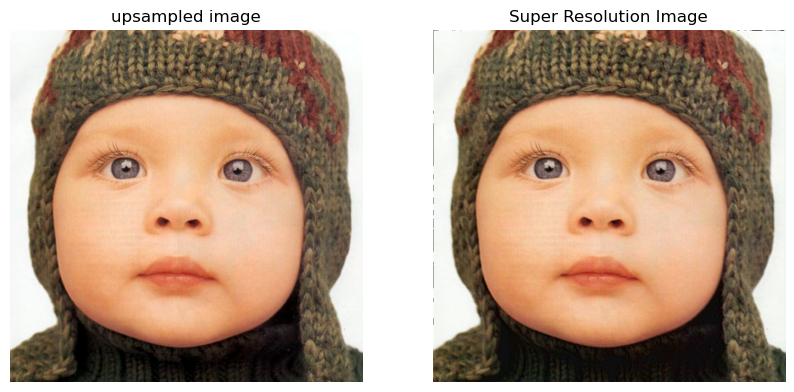

In [12]:
# 创建一个2x1的图像网格
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# 在第一个子图中显示原始图像
plt.subplot(1, 2, 1)
plt.imshow(upsampled_image)
plt.title("upsampled image")
plt.axis("off")

# 在第二个子图中显示超分辨率处理后的图像
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Super Resolution Image")
plt.axis("off")

# 显示图像
plt.show()